In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall

In [17]:
# Load the dataset
url = r"D:\Computer science\Year 3\Project COM3001\The App\Models\week_approach_maskedID_timeseries.csv"
data = pd.read_csv(url)
print(data)

       nr. sessions  nr. rest days  total kms  max km one day  \
0               5.0            2.0       22.2            16.4   
1               5.0            2.0       21.6            16.4   
2               5.0            2.0       21.6            16.4   
3               5.0            2.0       21.6            16.4   
4               6.0            1.0       39.2            17.6   
...             ...            ...        ...             ...   
42793           4.0            3.0       59.5            19.0   
42794           1.0            6.0        5.8             5.8   
42795           3.0            4.0       38.3            16.0   
42796           5.0            2.0       67.0            15.1   
42797           4.0            3.0       45.0            12.2   

       total km Z3-Z4-Z5-T1-T2  nr. tough sessions (effort in Z5, T1 or T2)  \
0                         11.8                                          1.0   
1                         11.7                               

In [23]:
feature_columns_week = [
    'nr. sessions', 'nr. rest days', 'total kms', 'max km one day', 'total km Z3-Z4-Z5-T1-T2', 
    'nr. tough sessions (effort in Z5, T1 or T2)', 'nr. days with interval session', 'total km Z3-4', 'max km Z3-4 one day',
    'total km Z5-T1-T2', 'max km Z5-T1-T2 one day', 'total hours alternative training', 
    'nr. strength trainings', 'avg exertion', 'min exertion', 'max exertion', 
    'avg training success', 'min training success', 'max training success', 
    'avg recovery', 'min recovery', 'max recovery',

    'nr. sessions.1', 'nr. rest days.1', 'total kms.1', 'max km one day.1', 'total km Z3-Z4-Z5-T1-T2.1',
    'nr. tough sessions (effort in Z5, T1 or T2).1', 'nr. days with interval session.1', 'total km Z3-4.1', 'max km Z3-4 one day.1',
    'total km Z5-T1-T2.1', 'max km Z5-T1-T2 one day.1', 'total hours alternative training.1', 
    'nr. strength trainings.1', 'avg exertion.1', 'min exertion.1', 'max exertion.1', 
    'avg training success.1', 'min training success.1', 'max training success.1', 
    'avg recovery.1', 'min recovery.1', 'max recovery.1',

    'nr. sessions.2', 'nr. rest days.2', 'total kms.2', 'max km one day.2', 'total km Z3-Z4-Z5-T1-T2.2',
    'nr. tough sessions (effort in Z5, T1 or T2).2', 'nr. days with interval session.2', 'total km Z3-4.2', 'max km Z3-4 one day.2',
    'total km Z5-T1-T2.2', 'max km Z5-T1-T2 one day.2', 'total hours alternative training.2', 
    'nr. strength trainings.2', 'avg exertion.2', 'min exertion.2', 'max exertion.2', 
    'avg training success.2', 'min training success.2', 'max training success.2', 
    'avg recovery.2', 'min recovery.2', 'max recovery.2'
]

target_column = 'injury'

# Extract features and target
X = data[feature_columns_week].values
Y = data[target_column].values

# Reshape X for LSTM input
sequence_length = 3  # 3 weeks
num_features = len(feature_columns_week) // sequence_length  # Number of features per day
X_LSTM = X.reshape(-1, sequence_length, num_features)
Y_LSTM = Y

# XGBOOST input
X_XGBOOST = X
Y_XGBOOST = Y

print(f"Shape of input for LSTM: {X_LSTM.shape}")  # (num_samples, 7, num_features)
print(f"Shape of input for XGBOOST: {X_XGBOOST.shape}")

Shape of input for LSTM: (42798, 3, 22)
Shape of input for XGBOOST: (42798, 66)


In [24]:
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, Y_LSTM, test_size=0.2, random_state=42)
X_train_BOOST, X_test_BOOST, Y_train_BOOST, Y_test_BOOST = train_test_split(X_XGBOOST, Y_XGBOOST, test_size=0.2, random_state=42)

575
42223


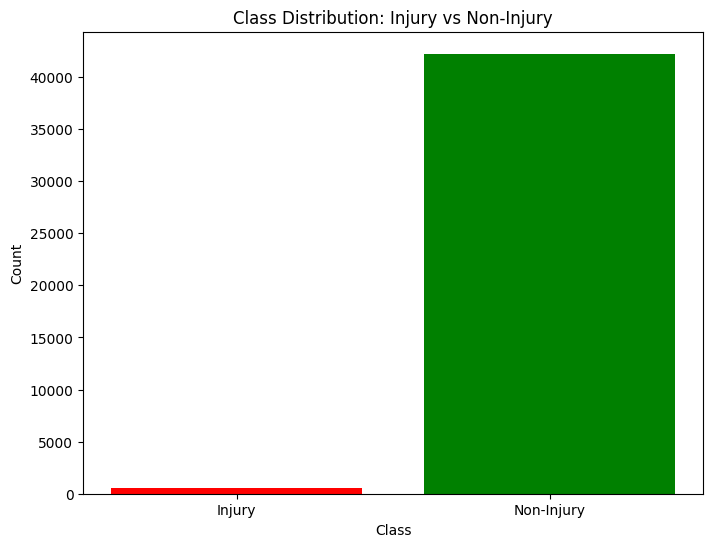

In [25]:
# It counts the first occurance as to the first variable
noninjury, injury = np.bincount(Y)
print(injury)
print(noninjury)

# Labels for the classes
labels = ['Injury', 'Non-Injury']
counts = [injury, noninjury]

# Plotting the bar chart
plt.figure(figsize=(8, 6))  # Set the size of the figure
plt.bar(labels, counts, color=['red', 'green'])  # Color for each class
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution: Injury vs Non-Injury')

# Display the plot
plt.show()


In [26]:
# Define the model
model = Sequential()

model.add(LSTM(50, input_shape=(sequence_length, num_features)))  # Return sequences for stacked LSTM
model.add(Dropout(0.2))  # Increase dropout rate

# Add a Dense output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

# Print the model summary
model.summary()

c:\Users\ench0\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        14,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,651 (57.23 KB)

 Trainable params: 14,651 (57.23 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(
    X_train_LSTM, Y_train_LSTM,
    epochs=20,  # Number of training iterations
    batch_size=32,  # Number of samples per gradient update
    validation_data=(X_test_LSTM, Y_test_LSTM),  # Evaluate on the test set during training
    class_weight = {0:1,1:8} # treats instances of 1 as 8 instances
)

Epoch 1/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9787 - loss: 0.3926 - precision: 0.0231 - recall: 0.0083 - val_accuracy: 0.9875 - val_loss: 0.1537 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9871 - loss: 0.3414 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9875 - val_loss: 0.1381 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9866 - loss: 0.3376 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9875 - val_loss: 0.1443 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9856 - loss: 0.3541 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9875 - val_loss: 0.1422 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9862 - loss: 0.3433 - precis

In [28]:
loss, accuracy = model.evaluate(X_test_LSTM, Y_test_LSTM)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.9865 - loss: 0.1079 - precision: 0.0000e+00 - recall: 0.0000e+00


ValueError: too many values to unpack (expected 2)

In [29]:
LSTMpredictions = model.predict(X_test_LSTM)

268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [30]:
# Train an XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
model.fit(X_train_BOOST, Y_train_BOOST)

# Make predictions
predictions = model.predict(X_train_BOOST)

# Evaluate the model performance
accuracy = accuracy_score(Y_train_BOOST, predictions)
precision = precision_score(Y_train_BOOST, predictions)
recall = recall_score(Y_train_BOOST, predictions)
f1 = f1_score(Y_train_BOOST, predictions)
conf_matrix = confusion_matrix(Y_train_BOOST, predictions)

# Print results
print("Predictions:", predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Optional: Detailed classification report
print("\nClassification Report:\n", classification_report(Y_train_BOOST, predictions))

Predictions: [0 0 0 ... 0 0 0]
Accuracy: 0.999707926864887
Precision: 1.0
Recall: 0.9786324786324786
F1 Score: 0.9892008639308856
Confusion Matrix:
 [[33770     0]
 [   10   458]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     33770
           1       1.00      0.98      0.99       468

    accuracy                           1.00     34238
   macro avg       1.00      0.99      0.99     34238
weighted avg       1.00      1.00      1.00     34238

